## EDA on hourly wind power and wind prediction dataset <br /> by Jerome Sauer, 17 December 2021 ##

In [70]:
## load modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import windrose as wr

In [71]:
## function to convert numerical wind direction into cardinal wind direction
def degrees_to_cardinal(d):
    dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
            "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    ix = int((d + 11.25)/22.5 - 0.02)
    return dirs[ix % 16]

## General structure of data ##

In [72]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
data.head()

,ZONEID,TARGETVAR,U10,V10,U100,V100
TIMESTAMP,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701


A couple of missing values in TARGETVAR. Otherwise no missing values.

In [73]:
## get info about type and shape of variables and about missing values in data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175440 entries, 2012-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ZONEID     175440 non-null  int64  
 1   TARGETVAR  175265 non-null  float64
 2   U10        175440 non-null  float64
 3   V10        175440 non-null  float64
 4   U100       175440 non-null  float64
 5   V100       175440 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 9.4 MB


In [74]:
## look at some general statistics in data
# number of timestamps in record correspond to the maximum possible timestamps
print(data.describe())
print(f"\nfirst wind power generation measurement and wind forecast data: {data.index.min()}")
print(f"last wind power generation measurement and wind forecast data: {data.index.max()}")
print(f"Different zones: {data['ZONEID'].unique()}")
print(f"maximum number of timestamps to expect: {(data.index.max() - data.index.min()).total_seconds() // 3600 + 1}")

             ZONEID      TARGETVAR            U10            V10  \
count  175440.00000  175265.000000  175440.000000  175440.000000   
mean        5.50000       0.358588       0.818499       0.120835   
std         2.87229       0.310085       3.031781       3.105553   
min         1.00000       0.000000      -8.371644     -12.923576   
25%         3.00000       0.080344      -1.498648      -2.116981   
50%         5.50000       0.278670       0.548880       0.410020   
75%         8.00000       0.602033       2.805379       2.364026   
max        10.00000       1.000000      14.837177      11.401396   

                U100           V100  
count  175440.000000  175440.000000  
mean        1.272769       0.058513  
std         4.816235       5.096587  
min       -12.425352     -19.791997  
25%        -2.404248      -3.768786  
50%         1.053103       0.785671  
75%         4.734727       4.091509  
max        21.399071      16.304799  

first wind power generation measurement and 

Linearly interpolate NaN values.

In [75]:
data.interpolate(method='linear', inplace=True)

Create columns with wind speed, wind direction, date, hour and month and cardinal wind direction.

In [76]:
data['WS10'] = data.apply(lambda x: np.sqrt(x['U10']**2 + x['V10']**2), axis=1)
data['WS100'] = data.apply(lambda x: np.sqrt(x['U100']**2 + x['V100']**2), axis=1)
data['WDIR100'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U100'], x['V100'])) % 360), axis=1)
data['WDIR10'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U10'], x['V10'])) % 360), axis=1)
data['HOUR'] = data.index.hour
data['DATE'] = data.index.date
data['MONTH'] = data.index.month
data['WDIR100_card'] = data.WDIR100.apply(lambda x: degrees_to_cardinal(x))
data['WDIR10_card'] = data.WDIR10.apply(lambda x: degrees_to_cardinal(x))
data.head()


,ZONEID,TARGETVAR,U10,V10,U100,V100,WS10,WS100,WDIR100,WDIR10,HOUR,DATE,MONTH,WDIR100_card,WDIR10_card
TIMESTAMP,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,321.999735,321.614439,1,2012-01-01,1,NW,NW
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,306.385781,305.473680,2,2012-01-01,1,NW,NW
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,289.088098,287.108562,3,2012-01-01,1,WNW,WNW
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,276.310236,273.345160,4,2012-01-01,1,W,W
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,263.581938,260.159324,5,2012-01-01,1,W,W


### Wind power and wind distributions for different wind parks ###

Same number of data for the different locations.

In [77]:
## every wind park the same number of observations?
data.groupby('ZONEID').count()

,TARGETVAR,U10,V10,U100,V100,WS10,WS100,WDIR100,WDIR10,HOUR,DATE,MONTH,WDIR100_card,WDIR10_card
ZONEID,,,,,,,,,,,,,,
1,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
2,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
3,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
4,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
5,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
6,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
7,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
8,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544
9,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544,17544


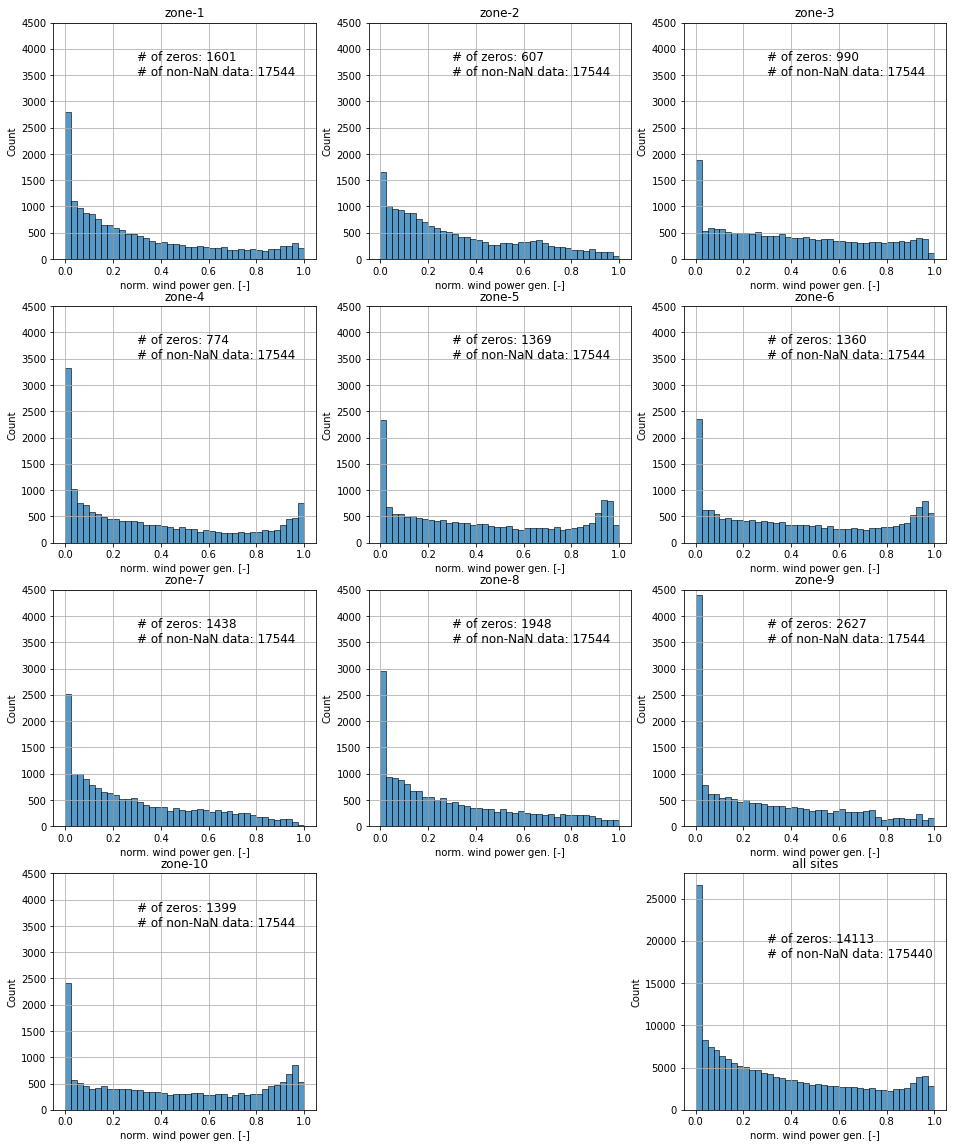

In [78]:
## distributions of wind power generation at the different sites
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(16,20))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data['TARGETVAR'].loc[data['ZONEID']==zone]
    sns.histplot(data=data_temp, ax=ax[i], bins=np.arange(0.,1.025,.025))
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel('norm. wind power gen. [-]')
    ax[i].set_ylim([0,4500])
    ax[i].grid()
    ax[i].text(.3,3500.,'# of zeros: {} \n# of non-NaN data: {}'.format((data_temp==0.).sum(),data_temp.count()),fontsize=12);
ax[-2].remove() 
sns.histplot(data=data['TARGETVAR'], ax=ax[-1], bins=np.arange(0.,1.025,.025))
ax[-1].grid()
ax[-1].set_xlabel('norm. wind power gen. [-]')
ax[-1].text(.3,18000.,'# of zeros: {} \n# of non-NaN data: {}'.format((data['TARGETVAR']==0.).sum(),data['TARGETVAR'].count()),fontsize=12)
ax[-1].set_title('all sites');

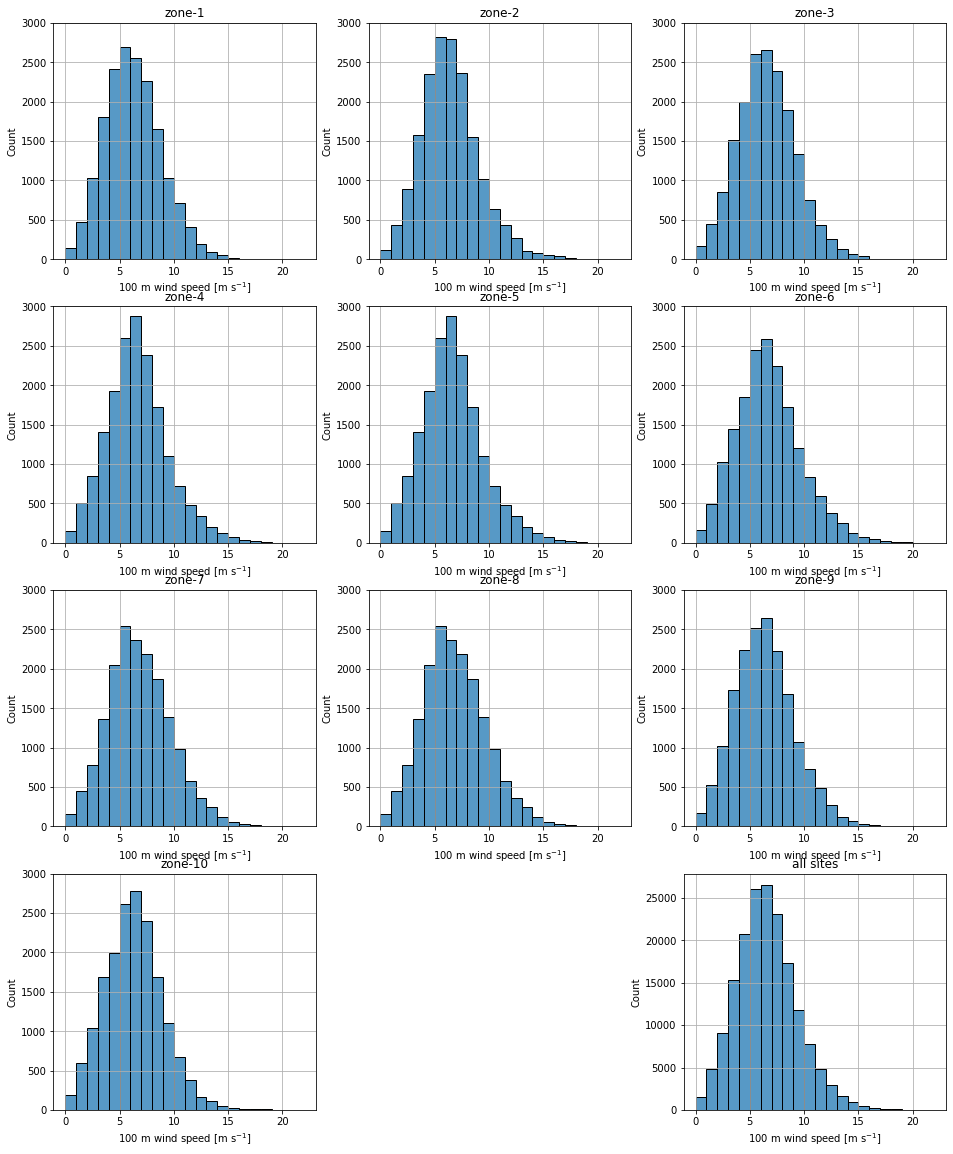

In [79]:
## distributions of wind speed at the different sites
fig,ax = plt.subplots(4,3,figsize=(16,20))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data['WS100'].loc[data['ZONEID']==zone]
    sns.histplot(data=data_temp, ax=ax[i], bins=np.arange(0.,23.,1.))
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel('100 m wind speed $\mathregular{[m\ s^{-1}]}$')
    ax[i].grid()
    ax[i].set_ylim([0,3000])
    
ax[-2].remove() 
sns.histplot(data=data['WS100'], ax=ax[-1], bins=np.arange(0.,23.,1.))
ax[-1].grid()
ax[-1].set_title('all sites')
ax[-1].set_xlabel('100 m wind speed $\mathregular{[m\ s^{-1}]}$');

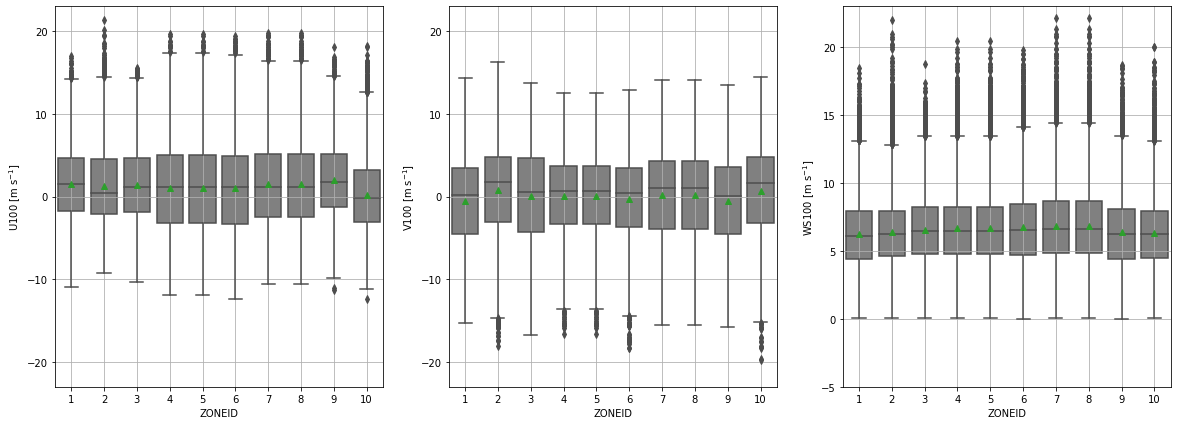

In [80]:
## distribution of zonal and meridional wind at the different sites
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
ax = np.reshape(ax,3)

for i,var in enumerate(['U100','V100','WS100']): 
    sns.boxplot(data=data, x='ZONEID', y=var, color='gray', showmeans=True, ax=ax[i])
    ax[i].grid()
    if i < 2:
        ax[i].set_ylim([-23.,23.])
    else:
        ax[i].set_ylim([-5.,23.])
    ax[i].set_ylabel('{} {}'.format(var,"$\mathregular{[m\ s^{-1}]}$"))

### Relationship between U100, V100 and wind power generation ###

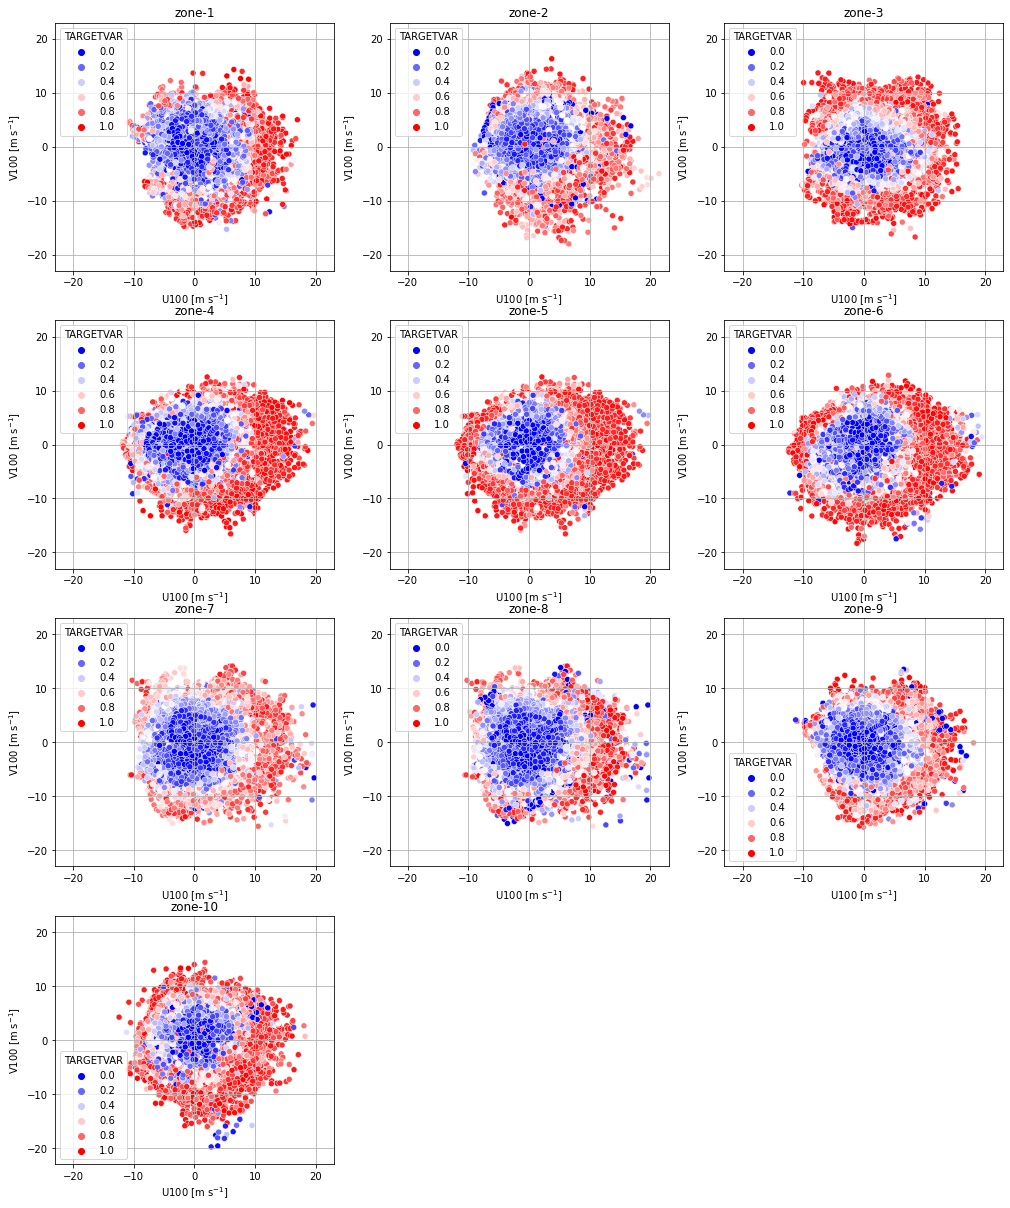

In [81]:
## scatter plots by wind farm: U100-V100-WS100
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    sns.scatterplot(data=data_temp, x='U100', y='V100', hue='TARGETVAR', palette='bwr', ax=ax[i])
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("U100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("V100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_xlim([-23.,23.])
    ax[i].set_ylim([-23.,23.])
    ax[i].grid()
ax[-1].remove()
ax[-2].remove()

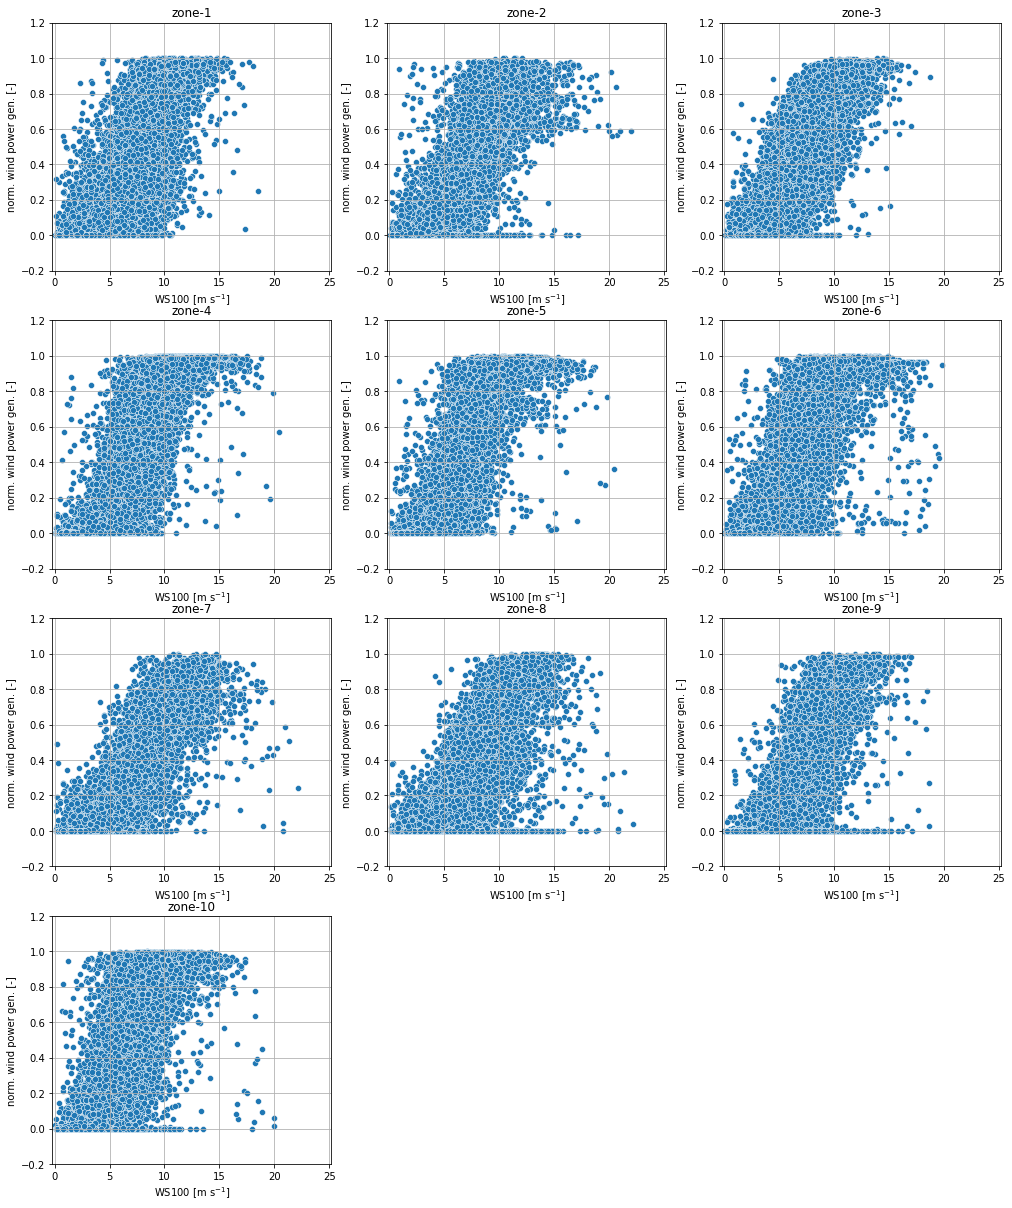

In [82]:
## scatter plots by wind farm: energy production by wind speed in 100 m above ground 
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    sns.scatterplot(data=data_temp, x='WS100', y='TARGETVAR',ax=ax[i])
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("WS100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("norm. wind power gen. [-]")
    ax[i].set_xlim([-0.2,25.2])
    ax[i].set_ylim([-0.2,1.2])
    ax[i].grid()
ax[-1].remove()
ax[-2].remove()

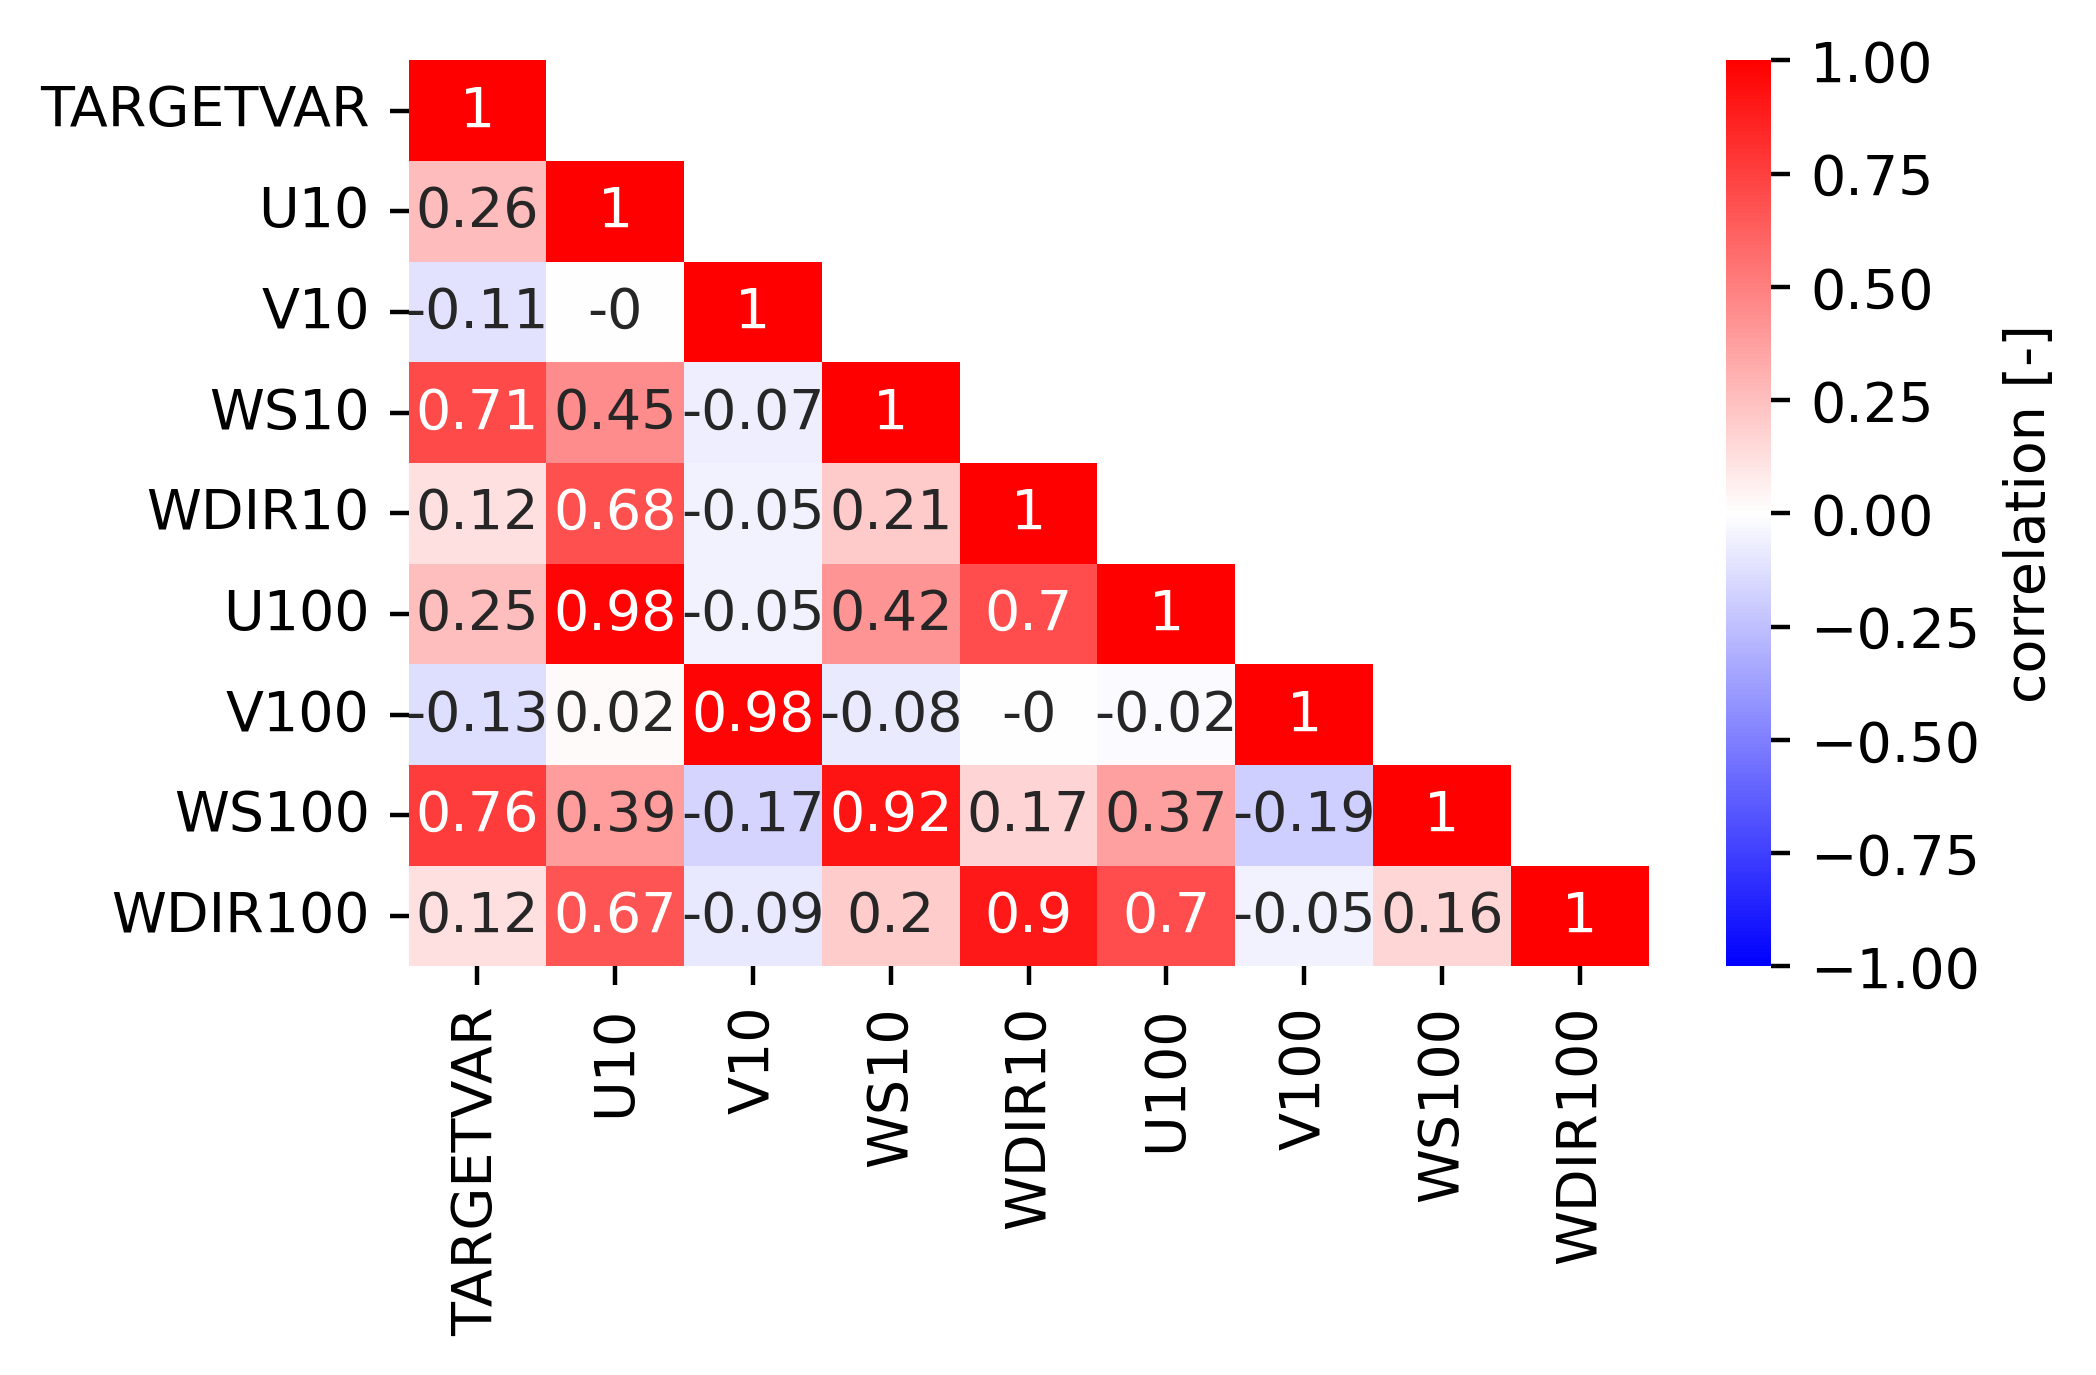

In [83]:
## correlation dataframe
data_temp = data[['TARGETVAR','U10','V10','WS10','WDIR10','U100','V100','WS100','WDIR100']].corr()

for row in range(len(data_temp)):
    data_temp.iloc[row,:] = [value if i <= row else np.nan for i,value in enumerate(data_temp.iloc[row,:])]

fig, ax = plt.subplots(figsize=(5,3), dpi=400)
sns.heatmap(data_temp.round(2), cmap='bwr', annot=True, vmin=-1., vmax=1., cbar_kws={'label': 'correlation [-]'}, ax=ax);


## Analysis by hour and month ##

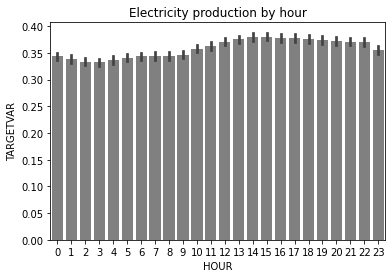

In [84]:
sns.barplot(data = data, x = 'HOUR', y = 'TARGETVAR', color='gray')
plt.title('Electricity production by hour')
plt.show()

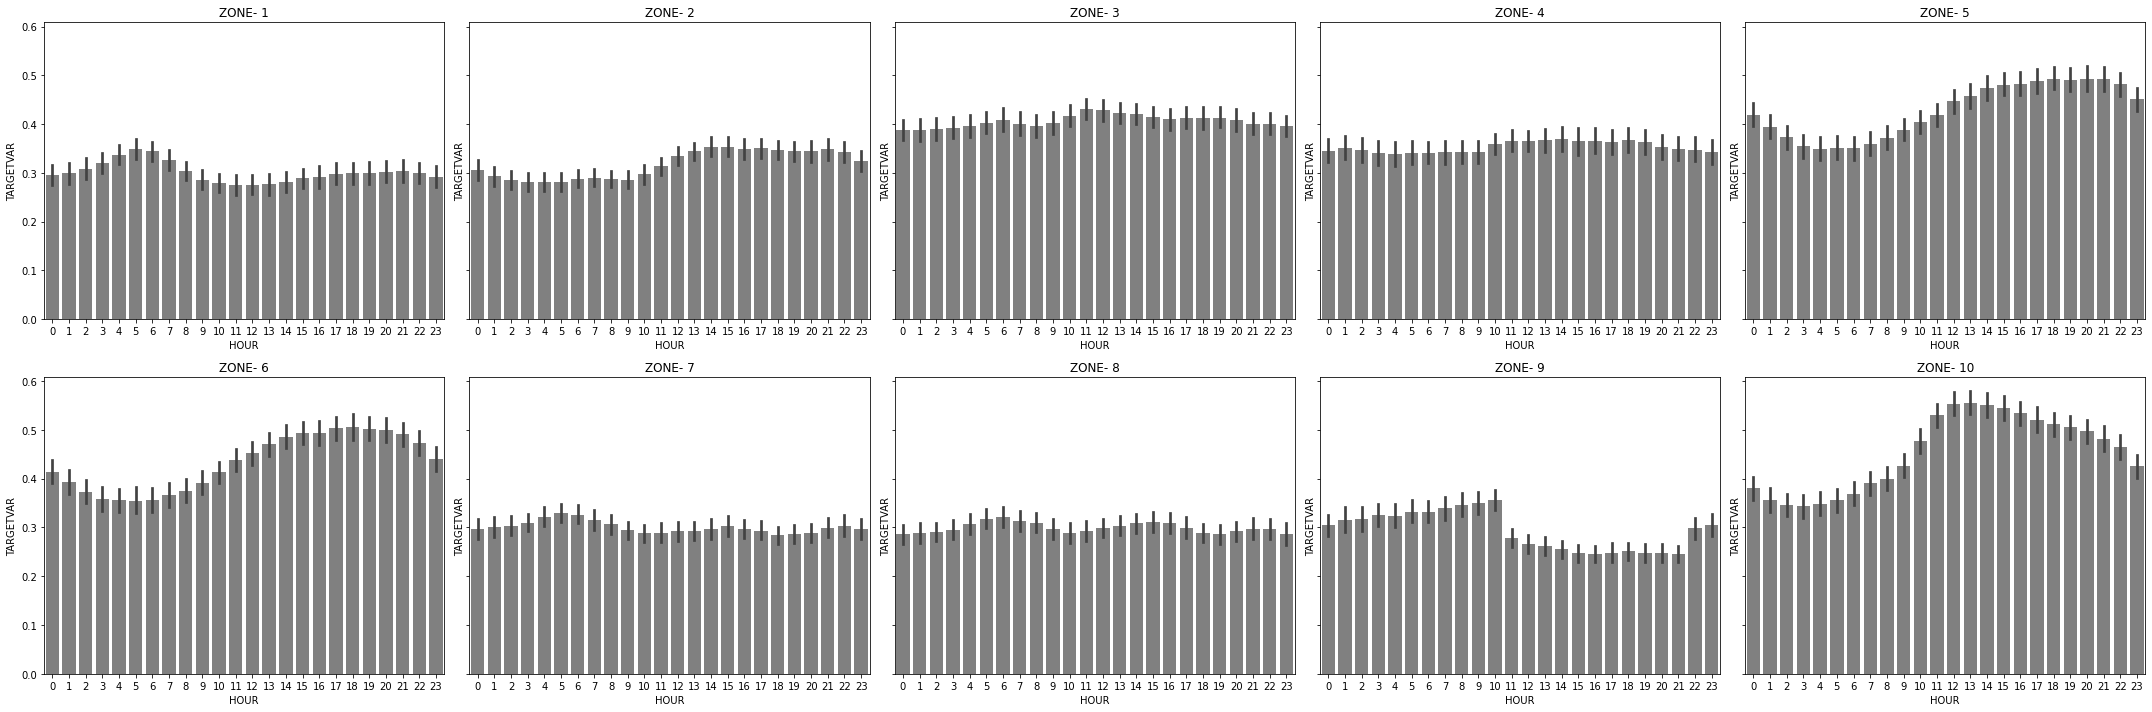

In [85]:
fig, ax = plt.subplots(2,5,figsize=(30,10),sharey=True)
ax = ax.ravel()
for zone in range(1,11):
    sns.barplot(data = data[data.ZONEID==zone], x = 'HOUR', y = 'TARGETVAR', color='gray', ax=ax[zone - 1])
    ax[zone - 1].set_title('ZONE- {}'.format(zone))
fig.tight_layout()

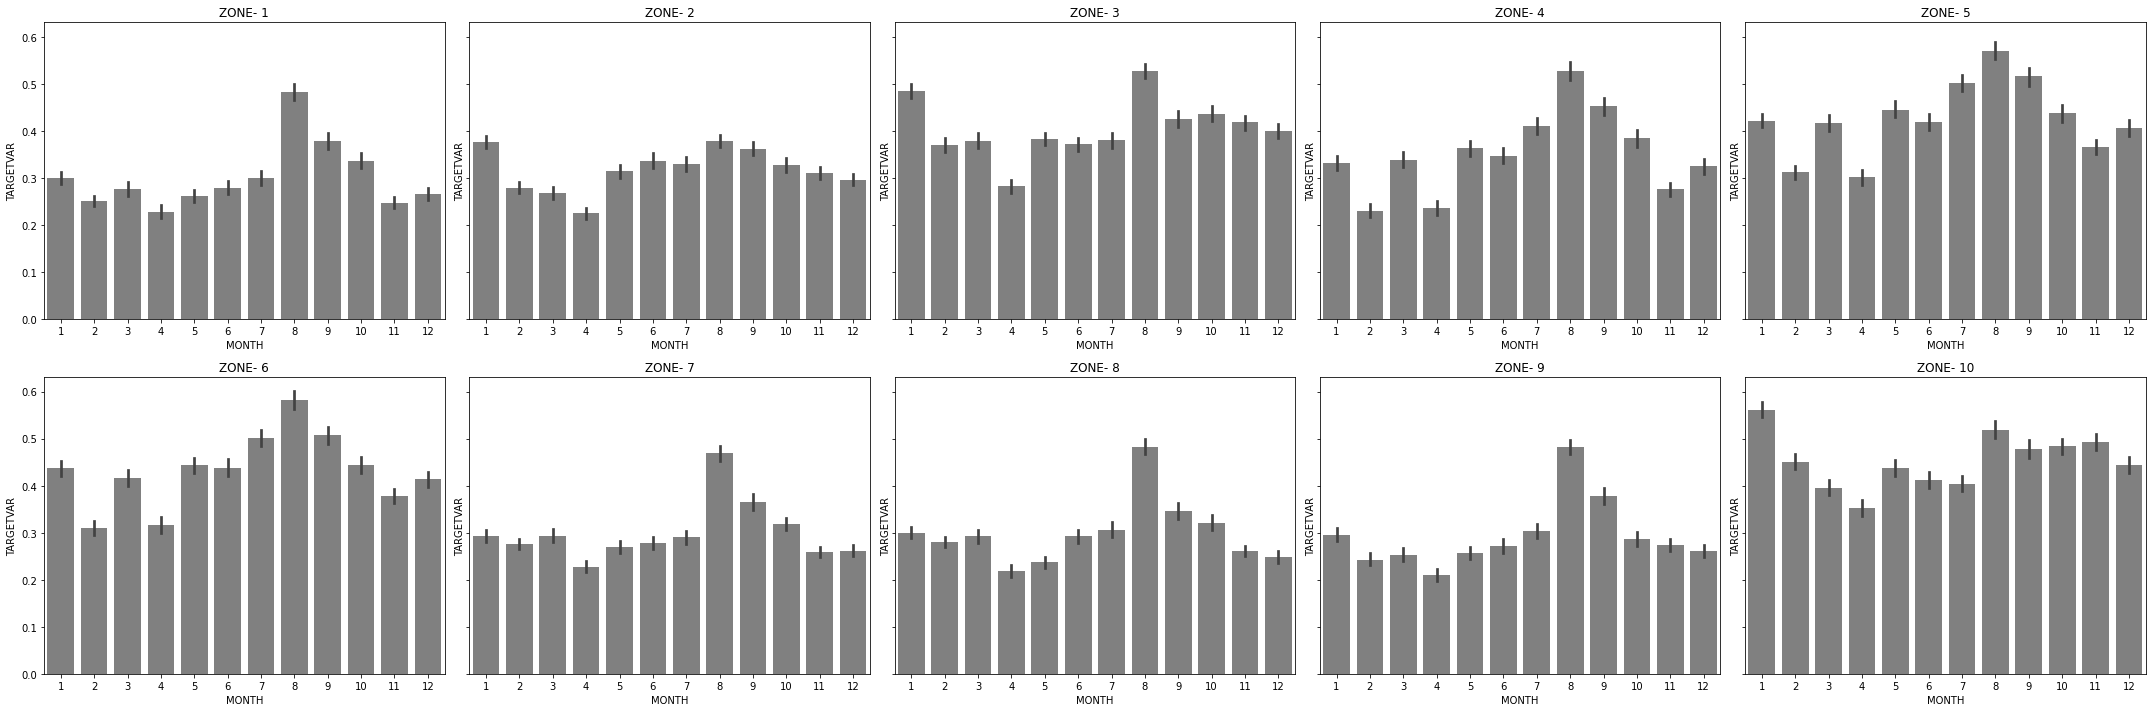

In [86]:
fig, ax = plt.subplots(2,5,figsize=(30,10),sharey=True)
ax = ax.ravel()
for zone in range(1,11):
    sns.barplot(data = data[data.ZONEID==zone], x = 'MONTH', y = 'TARGETVAR', color='gray', ax=ax[zone - 1])
    ax[zone - 1].set_title('ZONE- {}'.format(zone))
fig.tight_layout()

## Analysis by wind direction ##

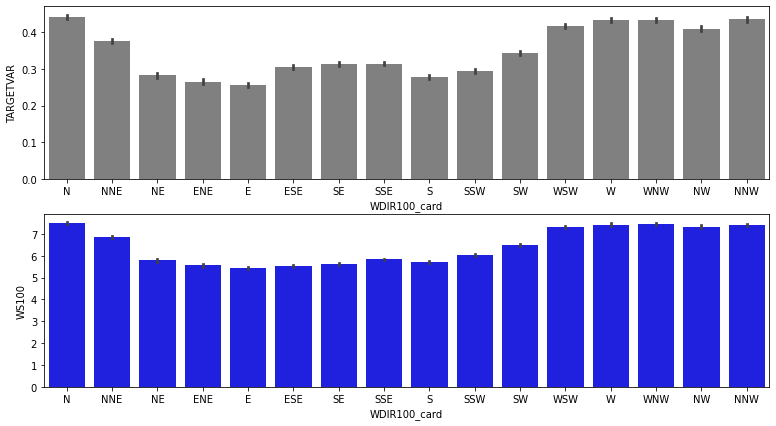

In [87]:
## wind power and wind speed by direction
order = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
fig,ax = plt.subplots(2,1,figsize=(13,7))
sns.barplot(data = data, x = 'WDIR100_card', y = 'TARGETVAR', order = order, ax=ax[0], color='gray');
sns.barplot(data = data, x = 'WDIR100_card', y = 'WS100', order = order, ax=ax[1], color='blue');

In [88]:
data.head()

,ZONEID,TARGETVAR,U10,V10,U100,V100,WS10,WS100,WDIR100,WDIR10,HOUR,DATE,MONTH,WDIR100_card,WDIR10_card
TIMESTAMP,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,321.999735,321.614439,1,2012-01-01,1,NW,NW
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,306.385781,305.473680,2,2012-01-01,1,NW,NW
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,289.088098,287.108562,3,2012-01-01,1,WNW,WNW
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,276.310236,273.345160,4,2012-01-01,1,W,W
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,263.581938,260.159324,5,2012-01-01,1,W,W


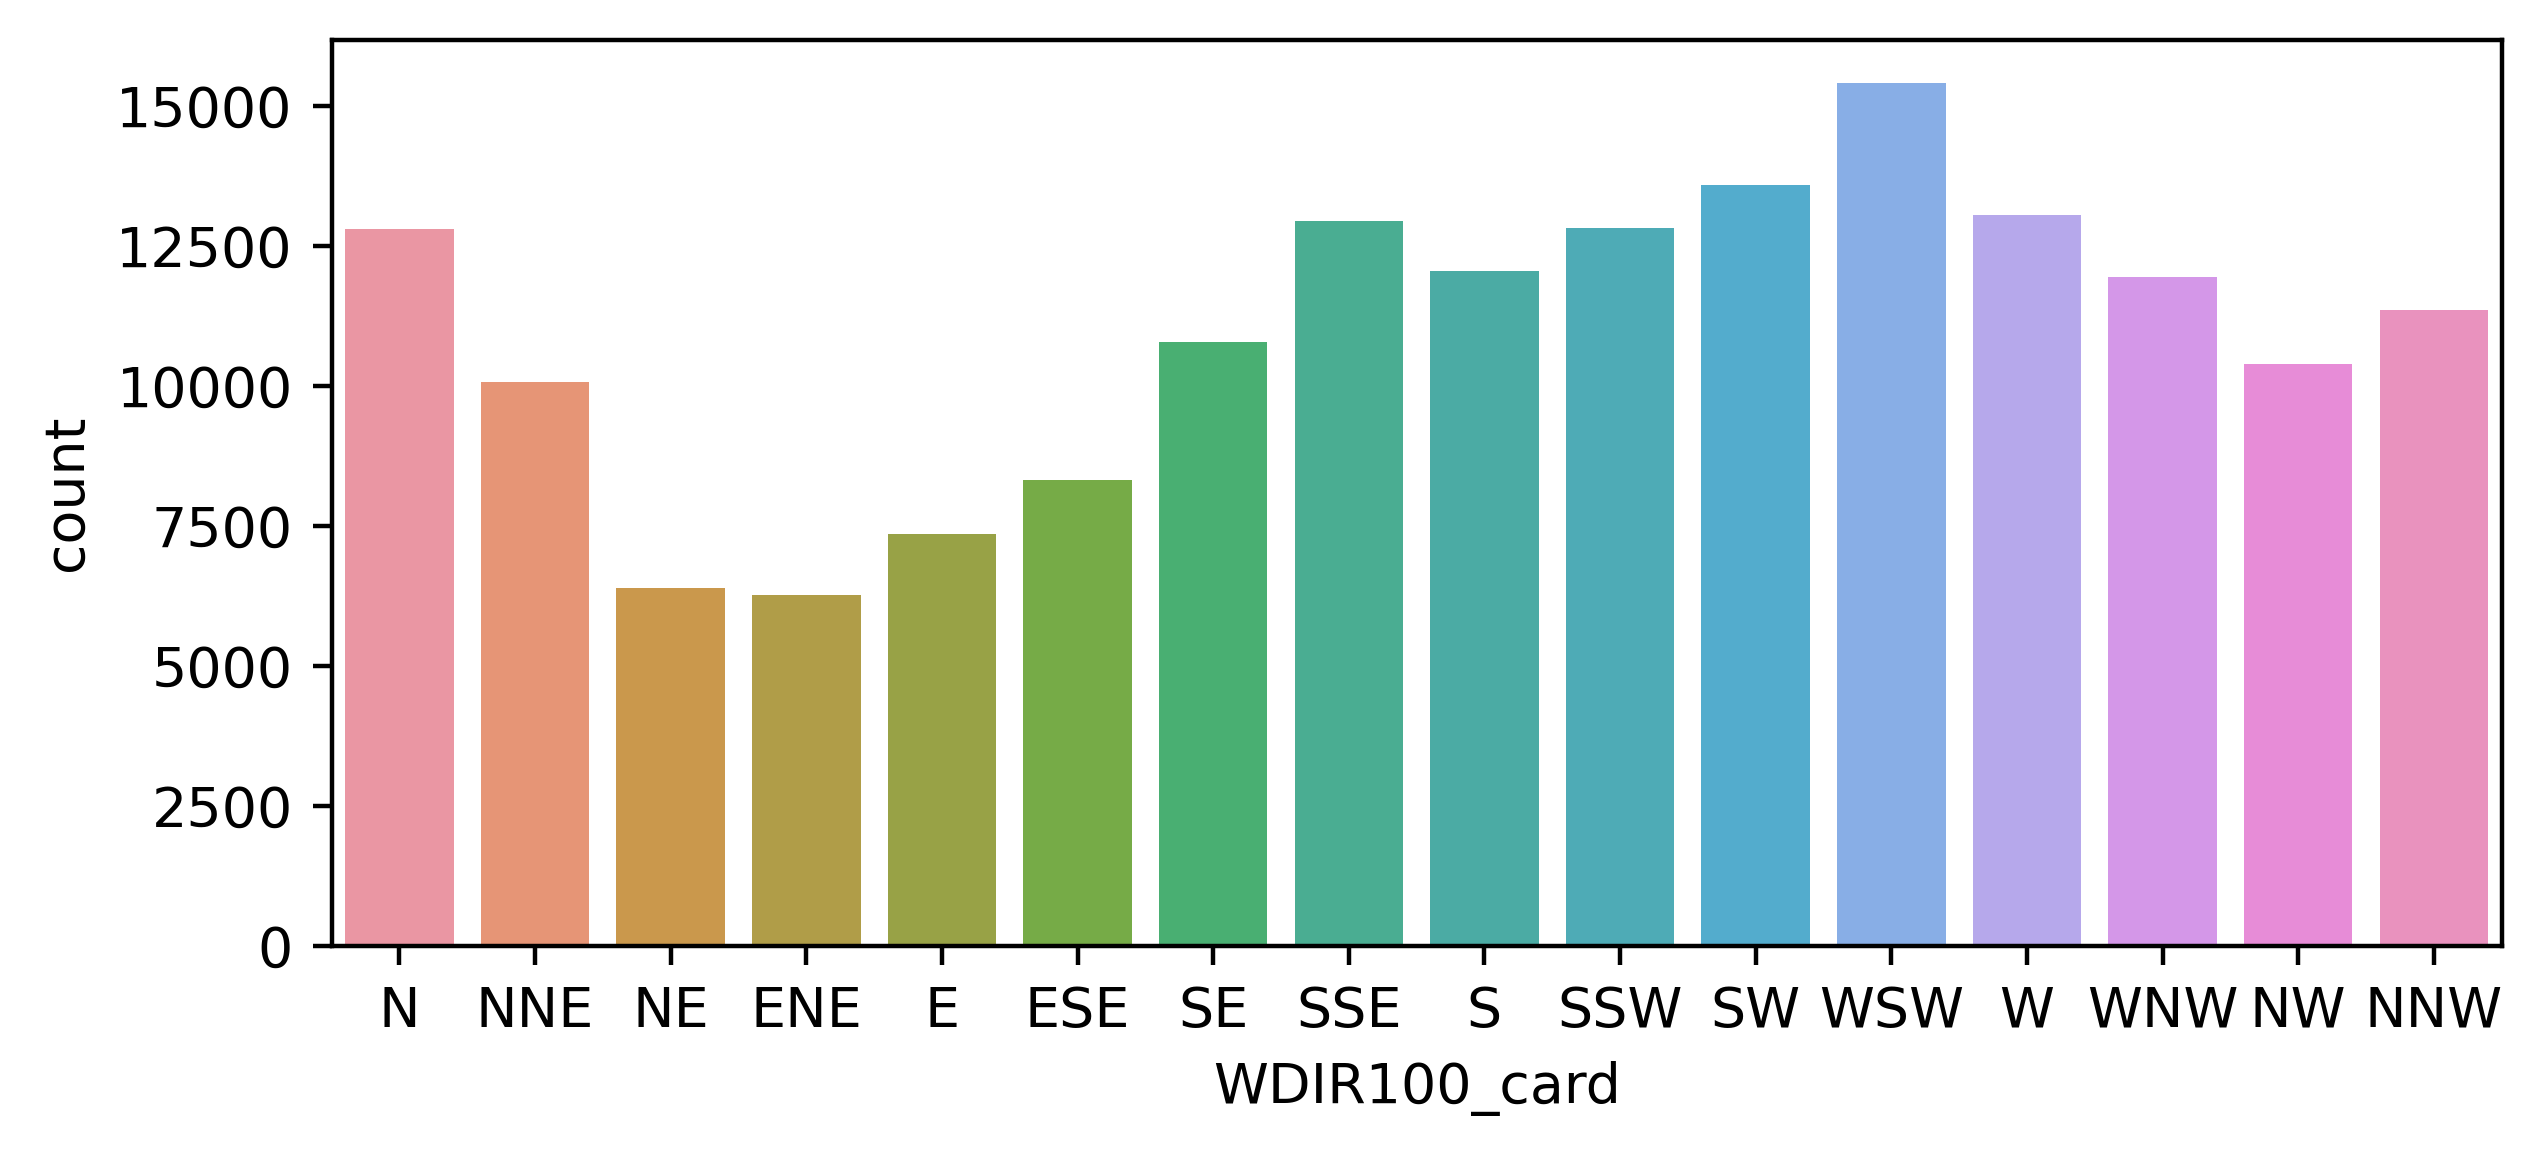

In [89]:
## frequency by direction
order = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
fig,ax = plt.subplots(figsize = (7,3), dpi=400)
sns.countplot(data = data, x = 'WDIR100_card', order = order, ax = ax);

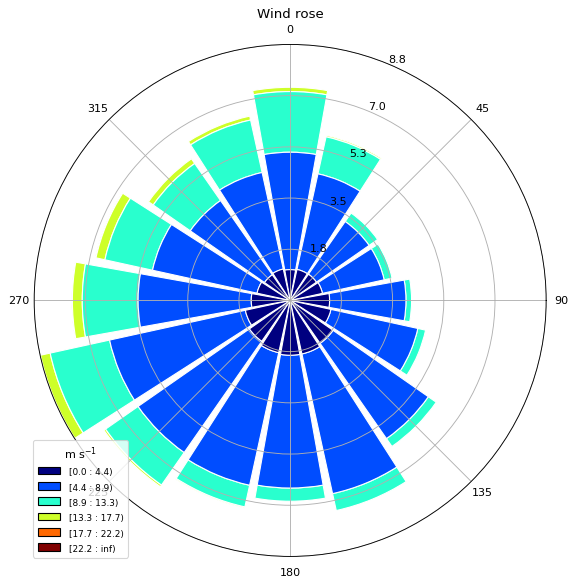

In [90]:
## Create windrose plot: frequency and wind speed by direction
ax = wr.WindroseAxes.from_ax(theta_labels = np.concatenate([np.arange(90,-45,-45),np.arange(315,90,-45)]))
ax.bar(data.WDIR100, data.WS100, normed = True, opening = .9, edgecolor = 'white')
ax.set_legend(title='$\mathregular{m\ s^{-1}}$')
ax.set_title('Wind rose')
plt.show()